In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import yasa
from scipy.signal import welch
import seaborn as sns
from scipy.signal import welch, freqz, butter, filtfilt
from mne.decoding import CSP

from sklearn.linear_model import RidgeClassifier, LinearRegression, Lasso, ElasticNet, BayesianRidge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB, ComplementNB

In [3]:
# CAR referencing

def reference(data):
    assert (data.shape[0] > data.shape[1]), "Check your rows are samples and columns are electrodes: " + str(data.shape)        
    ref = data - np.mean(data, axis = 1, keepdims = True)
    return ref


def butter_bandpass(lowcut, highcut, fs, order=9):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=9):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


def plot_spectrum(data, sf, window_sec, band=None, dB=False):
    """Plot the periodogram, Welch's and multitaper PSD.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds for Welch's PSD
    dB : boolean
        If True, convert the power to dB.
    """
    sns.set(style="white", font_scale=1.2)
    # Compute the PSD
    freqs_welch, psd_welch = welch(data, sf, nperseg=window_sec*sf)
    sharey = False

    # Optional: convert power to decibels (dB = 10 * log10(power))
    if dB:
        psd_welch = 10 * np.log10(psd_welch)
        sharey = True
    
    return freqs_welch, psd_welch

In [6]:
fs = 100
low = 7
high = 30

events = pd.read_csv('bad code/100Hz/data_set_IVb_al_train_mrk.txt', header=None, sep='\t')
events = np.squeeze(events.values.tolist())

# Import all the electrodes 
electrodes_all = pd.read_csv('bad code/100Hz/data_set_IVb_al_train_nfo.txt', header=None, delimiter=', ', nrows=1, engine='python')
electrodes_all = np.squeeze(electrodes_all.values.tolist())

# use the electrodes that span the motor cortex
first_electrode = np.where(electrodes_all=='CFC7')[0][0]
last_electrode = np.where(electrodes_all=='CCP8')[0][0]

electrodes25 = electrodes_all[first_electrode:last_electrode+1]

C1_ind25 = np.where(electrodes25=='C1')[0][0]
C2_ind25 = np.where(electrodes25=='C2')[0][0]
C3_ind25 = np.where(electrodes25=='C3')[0][0]
C4_ind25 = np.where(electrodes25=='C4')[0][0]
Cz_ind25 = np.where(electrodes25=='Cz')[0][0]

C1_ind = np.where(electrodes_all=='C1')[0][0]
C2_ind = np.where(electrodes_all=='C2')[0][0]
C3_ind = np.where(electrodes_all=='C3')[0][0]
C4_ind = np.where(electrodes_all=='C4')[0][0]
CP1_ind = np.where(electrodes_all=='CP1')[0][0]
CP2_ind = np.where(electrodes_all=='CP2')[0][0]
CP3_ind = np.where(electrodes_all=='CP3')[0][0]
CP4_ind = np.where(electrodes_all=='CP4')[0][0]
FC1_ind = np.where(electrodes_all=='FC1')[0][0]
FC2_ind = np.where(electrodes_all=='FC2')[0][0]
FC3_ind = np.where(electrodes_all=='FC3')[0][0]
FC4_ind = np.where(electrodes_all=='FC4')[0][0]
Cz_ind = np.where(electrodes_all=='Cz')[0][0]

data = pd.read_csv('bad code/100Hz/data_set_IVb_al_train_cnt.txt', names=electrodes_all, delimiter='\t')
data = data.to_numpy()

In [7]:
# Just filter one trial and see how much padding you need
data_cz = data - np.reshape(data[:, Cz_ind], (data.shape[0], 1))
data_car = reference(data)

data_cz_filt = np.zeros((data.shape[0], data.shape[1]))
for i in range(data.shape[1]):
    data_cz_filt[:, i] = butter_bandpass_filter(data_cz[:, i], low, high, fs, order=5)

data_car_filt = np.zeros((data.shape[0], data.shape[1]))
for i in range(data.shape[1]):
    data_car_filt[:, i] = butter_bandpass_filter(data_car[:, i], low, high, fs, order=5)

data25 = data[:, first_electrode: last_electrode+1]
data25_car = data_car[:, first_electrode: last_electrode+1]
data25_cz = data_cz[:, first_electrode: last_electrode+1]

data25_cz_filt = np.zeros((data25.shape[0], data25.shape[1]))
for i in range(data25.shape[1]):
    data25_cz_filt[:, i] = butter_bandpass_filter(data25_cz[:, i], low, high, fs, order=5)

data25_car_filt = np.zeros((data25.shape[0], data25.shape[1]))
for i in range(data25.shape[1]):
    data25_car_filt[:, i] = butter_bandpass_filter(data25_car[:, i], low, high, fs, order=5)


# C1_ref = data25_ref[:, C1_ind25]
# C2_ref = data25_ref[:, C2_ind25]
# C3_ref = data25_ref[:, C3_ind25]
# C4_ref = data25_ref[:, C4_ind25]
# Cz_ref = data25_ref[:, Cz_ind25]

Cz = data[:, Cz_ind]
C1_cz = data[:, C1_ind] - Cz #Cz reference has been the best!
C2_cz = data[:, C2_ind] - Cz
C3_cz = data[:, C3_ind] - Cz
C4_cz = data[:, C4_ind] - Cz

C1_cz_filt = butter_bandpass_filter(C1_cz, low, high, fs, order=5)
C2_cz_filt = butter_bandpass_filter(C2_cz, low, high, fs, order=5)
C3_cz_filt = butter_bandpass_filter(C3_cz, low, high, fs, order=5)
C4_cz_filt = butter_bandpass_filter(C4_cz, low, high, fs, order=5)


selected_electrodes = (np.vstack((C3_cz_filt, C4_cz_filt))).T
channels = selected_electrodes.shape[1]

print(selected_electrodes.shape)


(210259, 2)


Text(0.5, 1.0, 'Filtered')

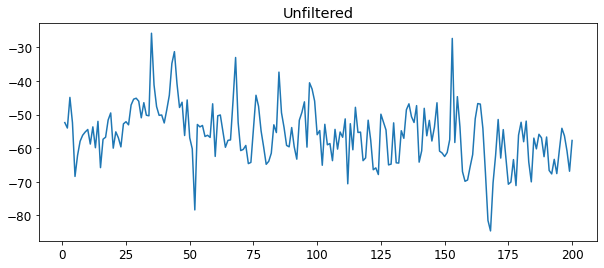

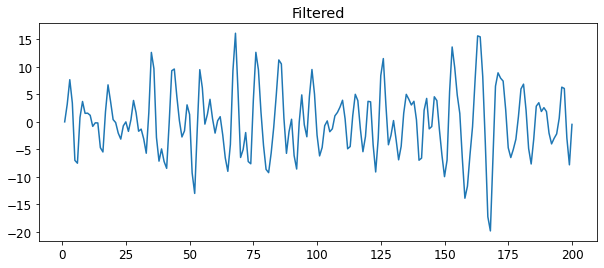

In [8]:
C3_trial1 = data_car[events[0][0]:events[0][0]+(2*fs), C3_ind]

t = range(1, 201)
plt.figure(figsize=(10, 4))
plt.plot(t, C3_trial1)
plt.title('Unfiltered')

C3_trial1_filt = butter_bandpass_filter(C3_trial1, low, high, fs, order=9)
plt.figure(figsize=(10, 4))
plt.plot(t, C3_trial1_filt)
plt.title('Filtered')

In [18]:
# Create training data

def create_data_csp(data, fs, sec):
    win = round(sec*fs)
    channels = data.shape[1]
    y = []
    x = np.zeros((len(events), channels, win))
    temp = np.zeros((channels, win))
    print(x.shape, temp.shape)
    
    for i in range(events.shape[0]):
        event = events[i]
        if (event[1] == 1):
            y.append(1)
        else:
            y.append(-1)
            
        all_channel_trial = data[event[0]:event[0]+win, :].T
        x[i, :, :] = all_channel_trial
        
    return x, y
            
    

x_csp, y = create_data_csp(data25_cz_filt, fs, 1)
print(x_csp.shape, print(len(y)))
# print(x_csp)

(210, 25, 100) (25, 100)
210
(210, 25, 100) None


In [19]:
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
x_train = csp.fit_transform(x_csp, y)

Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 25 dim * 2.4e+15  max singular value)
    Estimated rank (mag): 24
    MAG: rank 24 computed from 25 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 25 -> 24
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 25 dim * 2.3e+15  max singular value)
    Estimated rank (mag): 24
    MAG: rank 24 computed from 25 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 25 -> 24
Estimating covariance using EMPIRICAL
Done.


In [20]:
quantile_transformer = QuantileTransformer(random_state=0)
x_1 = quantile_transformer.fit_transform(x_train)

/opt/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2367: UserWarning: n_quantiles (1000) is greater than the total number of samples (210). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "


In [21]:
scores = cross_val_score(GaussianNB(), x_1, y, cv=KFold(x_1.shape[0])) # Best so far 90%
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean() * 100, scores.std()*2))

Accuracy: 75.24 (+/- 0.86)


In [22]:
scores = cross_val_score(SVC(kernel='poly', degree=2), x_train, y, cv=KFold(x_train.shape[0])) # 2nd Best so far 90%
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean() * 100, scores.std()*2))

Accuracy: 77.62 (+/- 0.83)


In [23]:
scores = cross_val_score(SVC(kernel='poly', degree=3), x_train, y, cv=KFold(x_train.shape[0])) # 2nd Best so far 90%
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean() * 100, scores.std()*2))

Accuracy: 75.24 (+/- 0.86)


In [82]:
scores = cross_val_score(SVC(kernel='rbf'), x_train, y, cv=KFold(x_train.shape[0])) # Best so far 91%
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean() * 100, scores.std()*2))

Accuracy: 74.29 (+/- 0.87)


In [83]:
scores = cross_val_score(LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen'), x_train, y, cv=KFold(x_train.shape[0]))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean() * 100, scores.std()*2))

Accuracy: 76.67 (+/- 0.85)


In [84]:
scores = cross_val_score(LogisticRegression(max_iter=1000), x_train, y, cv=KFold(x_train.shape[0]))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean() * 100, scores.std()*2))

Accuracy: 78.10 (+/- 0.83)
